In [1]:
import sys
sys.path.insert(0,'C:\\Users\\nakaa1\\code\\PsychRNN')
sys.path.insert(0,'/Users/nakaa1/code/py/PsychRNN/')

import psychrnn
from psychrnn.tasks import rdm as rd
from psychrnn.backend.models.basic import Basic, BasicSigmoid
import numpy as np
import tensorflow as tf
from matplotlib import pyplot as plt
%matplotlib inline
import importlib
importlib.reload(psychrnn)

# from brian2 import *

<module 'psychrnn' from '/Users/nakaa1/code/py/PsychRNN/psychrnn/__init__.py'>

define params globally first before passing to RDM, mess w/ model params and explain what can do. (can turn on and off dale's law). some masking, input output connectivity. train_params variables stuff

In [94]:
dt = 1 # time-step
tau = 10 # intrinsic time constant of neural state decay
T = 50 # time to run for (number of steps is T/dt)
N_batch = 25 # number of trials per training step
N_rec = 200 # number of recurrent units
name = 'basicModel'
N_in = 50
N_out = 51

In [95]:
from psychrnn.tasks.task import Task

def gaussian_input(N_in, mu = 0, sigma = 1):
    y = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (np.arange(N_in) - mu)**2 / (2 * sigma**2)))
    y = y/np.max(y)
    return y

"""
Binary Decision task. 
Takes two channels of noisy input.
Binary output with a one hot encoding towards the higher mean channel
"""

class noisy_decode(Task):
    
    def __init__(self, N_in, N_out, dt, tau, T, N_batch):
        super(noisy_decode,self).__init__(N_in, N_out, dt, tau, T, N_batch)
        
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.5 
        params['response_delay'] = 0
        params['duration'] = 25
        params['mu'] = np.random.randint(self.N_in)
        params['sigma'] = np.random.choice([3,4,5,6,7,8])
        params['neuron_noise'] = 1
        params['baseline_rate'] = 0
        params['peak_rate'] = np.random.choice(30)+1
        true_rates = gaussian_input(N_in = N_in,
                                              mu = params['mu'],
                                              sigma = params['sigma']) * params['peak_rate']
        true_rates[true_rates<0.01] = 0
        params['true_rates'] = true_rates.copy()
        params['N_input_dropout'] = 0
        params['input_drops'] = np.random.choice(self.N_in, size = params['N_input_dropout'], replace = False)
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) + params['baseline_rate'] + np.random.randn(self.N_in)*params['neuron_noise']
        y_t = np.zeros(self.N_out) + params['baseline_rate'] 
        mask_t = np.ones(self.N_out) 

        
        if (t>params['onset']) and (t<(params['onset']+params['duration'])):
            x_t += params['true_rates'] 
        
        if (t>params['onset']+params['response_delay']) and (t<(params['onset']+params['duration']+params['response_delay'])):
            y_t += params['true_rates']
        for x in params['input_drops']:
            x_t[x] = 0
        x_t[x_t<0] = 0
        return x_t, y_t, mask_t

    

    
class noisy_decode_plus_pain(Task):
    
    def __init__(self, N_in, N_out, dt, tau, T, N_batch):
        super(noisy_decode_plus_pain,self).__init__(N_in, N_out, dt, tau, T, N_batch)
        
                                    #N_in, N_out
    def generate_trial_params(self, batch, trial):

        # ----------------------------------
        # Define parameters of a trial
        # ----------------------------------
        params = dict()
        params['onset'] = np.random.rand() * T * 0.5 
        params['response_delay'] = 0
        params['duration'] = 60
        params['mu'] = np.random.randint(self.N_in)
        params['sigma'] = np.random.choice([3])
        params['neuron_noise'] = 2
        params['baseline_rate'] = 0
        params['peak_rate'] = np.random.choice(20)+5
        true_rates = gaussian_input(N_in = N_in,
            mu = params['mu'],
            sigma = params['sigma']) * params['peak_rate']
        true_rates[true_rates<0.01] = 0
        params['true_rates'] = true_rates.copy()
        params['N_input_dropout'] = 0
        params['input_drops'] = np.random.choice(self.N_in, size = params['N_input_dropout'], replace = False)
        params['pain_thresh'] = 15
        params['frac_pain_out'] = 0.02
        params['N_out_pain'] = int(self.N_out *  params['frac_pain_out'])
        params['N_out_norm'] = self.N_out - params['N_out_pain']
        params['out_norm_ind'] = np.arange(self.N_out)<params['N_out_norm']
        params['out_pain_ind'] = np.arange(self.N_out)>=params['N_out_norm']
        params['pain_weight'] = 10
        return params

    def trial_function(self, t, params):
        
        x_t = np.zeros(self.N_in) + params['baseline_rate'] + np.random.randn(self.N_in)*params['neuron_noise']
        yn_t = np.zeros(params['N_out_norm']) + params['baseline_rate']
        
        # mask can be used for weighting
        maskn_t = np.ones(params['N_out_norm']) 
        maskp_t = np.ones(params['N_out_pain']) * params['pain_weight']
        mask_t = np.concatenate([maskn_t, maskp_t])
        
        if (t>params['onset']) and (t<(params['onset']+params['duration'])):
            x_t += params['true_rates'] 
            
        for x in params['input_drops']:
            x_t[x] = 0
        x_t[x_t<0] = 0
        
        if (t>params['onset']+params['response_delay']) and (t<(params['onset']+params['duration']+params['response_delay'])):
            yn_t += params['true_rates']
        
        yp_t = np.zeros(params['N_out_pain'])
        if (t>params['onset']+params['response_delay']) and (t<(params['onset']+params['duration']+params['response_delay'])):
            rates = params['true_rates'].copy()
#             rates = rates[rates>=params['pain_thresh']]
            rates -= params['pain_thresh']
            rates[rates<0] = 0
            rate_sum = sum(rates) 
            yp_t += rate_sum 
        
        y_t = np.concatenate([yn_t,yp_t])
        
        return x_t, y_t, mask_t

In [96]:
# swv = noisy_decode(N_in = N_in, N_out = N_out,dt = dt, tau = tau, T = T, N_batch = N_batch)
swv = noisy_decode_plus_pain(N_in = N_in, N_out = N_out,dt = dt, tau = tau, T = T, N_batch = N_batch)
gen = swv.batch_generator()
params = swv.__dict__

In [97]:
yn_ind = swv.generate_trial_params(0,0)['out_norm_ind']
yp_ind = swv.generate_trial_params(0,0)['out_pain_ind']
N_yn = swv.generate_trial_params(0,0)['N_out_norm']

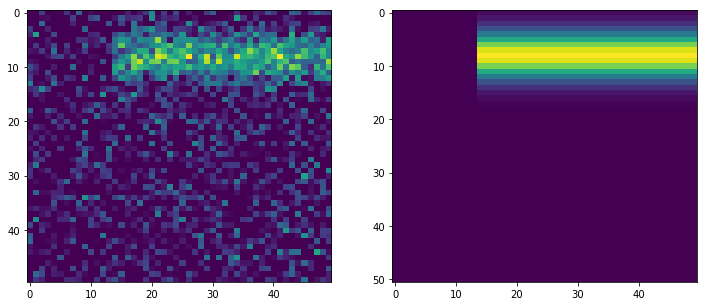

In [98]:
x,y,m = next(gen)
f,ax = plt.subplots(1,2,figsize = (12,5))
ax[0].imshow(x[0,:,:].T,aspect = 'auto')
ax[1].imshow(y[0,:,:].T,aspect = 'auto')

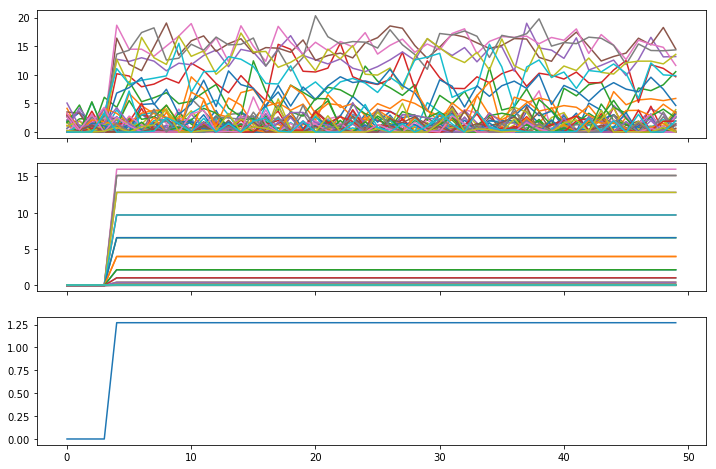

In [99]:
x,y,m = next(gen)
i = 0
f,ax = plt.subplots(3,1,figsize = (12,8),sharex = True)
ax[0].plot(x[i,:,:]);
ax[1].plot(y[i,:,:N_yn]);
ax[2].plot(y[i,:,N_yn:]);

There are some other optional parameters we can add in:

In [100]:
params['name'] = name #Used to scope out a namespace for global variables.
params['N_rec'] = N_rec
params['dale_ratio'] = None # Default: None -- when the dale_ratio is set, dale's law is applied
params['rec_noise'] = 0.0 # Default: 0.0 -- how much noise to add to the new_state calculation
params['W_in_train'] = True # Indicates whether W_in is trainable. Default: True
params['W_rec_train'] = True # Indicates whether W_rec is trainable. Default: True
params['W_out_train'] = True # Indicates whether W_out is trainable. Default: True
params['b_rec_train'] = True # Indicates whether b_rec is trainable. Default: True
params['b_out_train'] = True # Indicates whether b_out is trainable. Default: True
params['init_state_train'] = True # Indicates whether init_state is trainable. Default: True
params['load_weights_path'] = None # When given a path, loads weights from file in that path. Default: None

params['L2_out'] = 0
params['L2_rec'] = 0
params['L2_in'] = 0
params['L2_firing_rate_reg'] = 0

params['L1_firing_rate_reg'] = 0
params['L1_out'] = 0
params['L1_in'] = 0
params['L1_rec'] = 0

In [101]:
try:
    basicModel.destruct()
except:
    pass
basicModel = Basic(params)
basicModel.build()

In [102]:
train_params = {}
train_params['save_weights_path'] =  '../weights/refactor_weights.npz' # Where to save the model after training. Default: None
train_params['training_iters'] = 15000 # number of iterations to train for Default: 10000
train_params['learning_rate'] = .001 # Sets learning rate if use default optimizer Default: .001
train_params['loss_epoch'] = 10 # Compute and record loss every 'loss_epoch' epochs. Default: 10
train_params['verbosity'] = True # If true, prints information as training progresses. Default: True
train_params['save_training_weights_epoch'] = 100 # save training weights every 'save_training_weights_epoch' epochs. Default: 100
train_params['training_weights_path'] = None # where to save training weights as training progresses. Default: None
train_params['generator_function'] = None # replaces trial_batch_generator with the generator_function when not none. Default: None
train_params['optimizer'] = tf.train.AdamOptimizer(learning_rate=train_params['learning_rate']) # What optimizer to use to compute gradients. Default: tf.train.AdamOptimizer(learning_rate=train_params['learning_rate'])
train_params['clip_grads'] = True # If true, clip gradients by norm 1. Default: True
train_params

{'save_weights_path': '../weights/refactor_weights.npz',
 'training_iters': 15000,
 'learning_rate': 0.001,
 'loss_epoch': 10,
 'verbosity': True,
 'save_training_weights_epoch': 100,
 'training_weights_path': None,
 'generator_function': None,
 'optimizer': <tensorflow.python.training.adam.AdamOptimizer at 0x15afeda90>,
 'clip_grads': True}

In [103]:
basicModel.train(gen, train_params)

Iter 250, Minibatch Loss= 114.783920
Iter 500, Minibatch Loss= 144.078796
Iter 750, Minibatch Loss= 122.172554
Iter 1000, Minibatch Loss= 163.212860
Iter 1250, Minibatch Loss= 115.620094
Iter 1500, Minibatch Loss= 90.097061
Iter 1750, Minibatch Loss= 92.407074
Iter 2000, Minibatch Loss= 58.668343
Iter 2250, Minibatch Loss= 53.245213
Iter 2500, Minibatch Loss= 110.826248
Training weights saved in file: None100
Iter 2750, Minibatch Loss= 106.252693
Iter 3000, Minibatch Loss= 40.913338
Iter 3250, Minibatch Loss= 95.376129
Iter 3500, Minibatch Loss= 100.981422
Iter 3750, Minibatch Loss= 141.908524
Iter 4000, Minibatch Loss= 41.345303
Iter 4250, Minibatch Loss= 73.222633
Iter 4500, Minibatch Loss= 61.961491
Iter 4750, Minibatch Loss= 48.246750
Iter 5000, Minibatch Loss= 59.730453
Training weights saved in file: None200
Iter 5250, Minibatch Loss= 46.228157
Iter 5500, Minibatch Loss= 95.343498
Iter 5750, Minibatch Loss= 94.185997
Iter 6000, Minibatch Loss= 78.134384
Iter 6250, Minibatch Loss=

([114.78392,
  144.0788,
  122.172554,
  163.21286,
  115.620094,
  90.09706,
  92.407074,
  58.668343,
  53.245213,
  110.82625,
  106.25269,
  40.913338,
  95.37613,
  100.98142,
  141.90852,
  41.345303,
  73.22263,
  61.96149,
  48.24675,
  59.730453,
  46.228157,
  95.3435,
  94.186,
  78.134384,
  76.73591,
  123.677124,
  80.83137,
  74.58028,
  63.966084,
  49.08678,
  71.65857,
  41.660564,
  41.808872,
  52.346104,
  45.665264,
  57.01512,
  47.47113,
  64.95303,
  66.32608,
  47.744793,
  51.133354,
  51.979305,
  67.53936,
  57.45646,
  44.78492,
  62.686256,
  64.24403,
  39.979248,
  53.666016,
  38.94238,
  38.89563,
  37.16072,
  49.447914,
  32.4521,
  40.8872,
  35.50405,
  55.016243,
  29.277445,
  43.063473],
 108.16472506523132,
 4.8368871212005615)

In [104]:
x,y,m = next(gen)
results = basicModel.test(x)
output = results[0]
state_var = results[1]

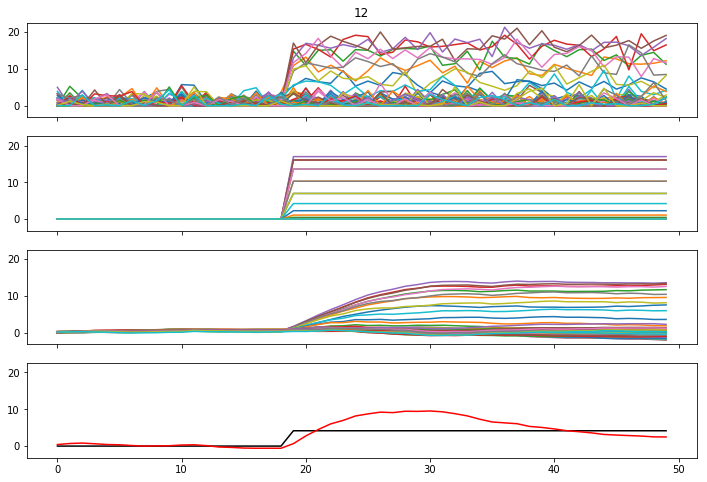

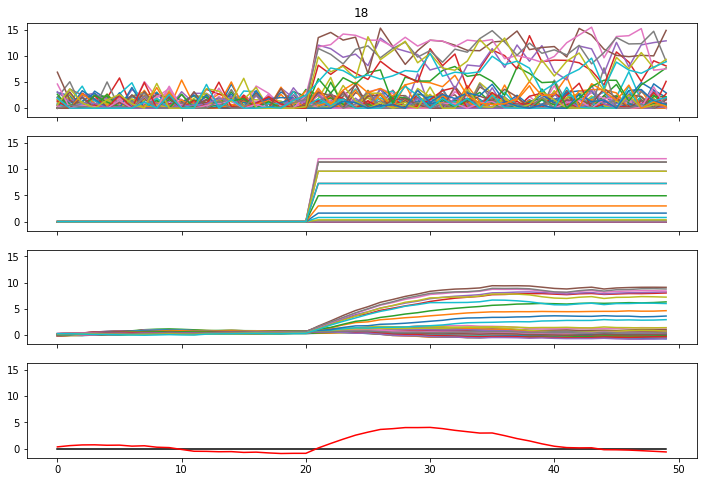

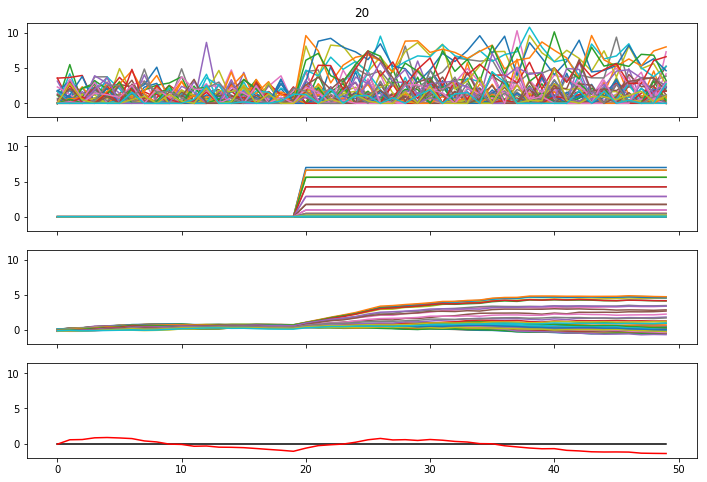

In [105]:
for i in np.random.choice(params['N_batch'],size = 3):
    f,ax = plt.subplots(4,1,figsize = (12,8),sharey = True, sharex = True)
    ax[0].plot(range(0, len(x[i,:,:])*dt,dt), x[i,:,:]);
    ax[0].set_title(i)
    ax[1].plot(range(0, len(y[i,:,:N_yn])*dt,dt), y[i,:,:N_yn]);
    ax[2].plot(range(0, len(output[i,:,:N_yn])*dt,dt),output[i,:,:N_yn]);
    ax[3].plot(range(0, len(y[i,:,N_yn:])*dt,dt),y[i,:,N_yn:],'k');
    ax[3].plot(range(0, len(output[i,:,N_yn:])*dt,dt),output[i,:,N_yn:],'r');
    plt.tight_layout

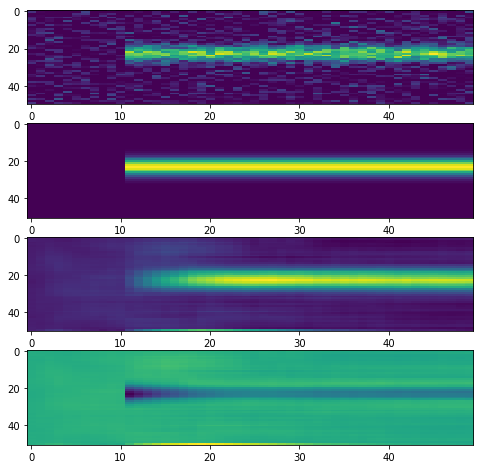

In [106]:
i = 17
f,ax = plt.subplots(4,1,figsize = (8,8))
ax[0].imshow(x[i,:,:].T,aspect = 'auto');
ax[1].imshow(y[i,:,:].T,aspect = 'auto');
ax[2].imshow(output[i,:,:].T,aspect = 'auto');
ax[3].imshow(output[i,:,:].T-y[i,:,:].T,aspect = 'auto');

In [107]:
weights = basicModel.get_weights()
E = np.diag(weights['Dale_rec'])>0
I = np.diag(weights['Dale_rec'])<0

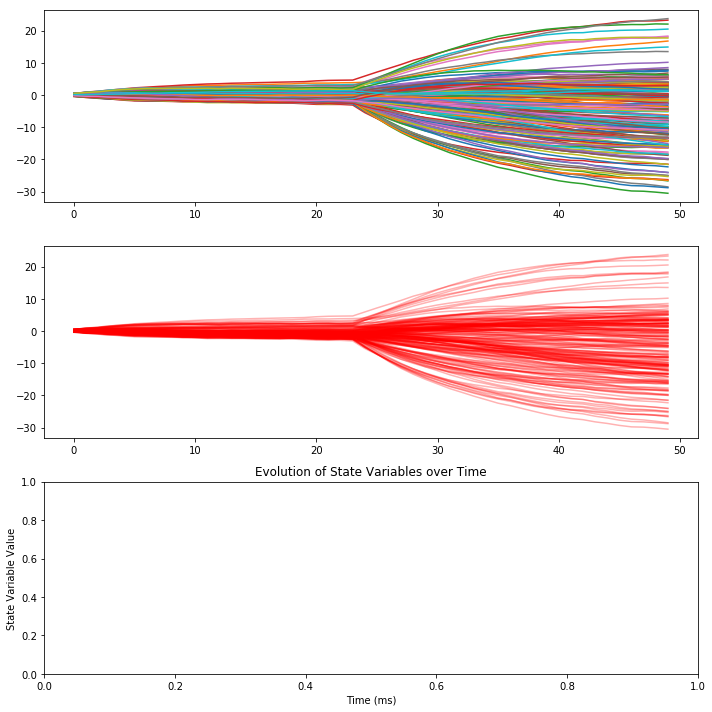

In [108]:
i = 8
f,ax = plt.subplots(3,1,figsize = (10,10))

ax[0].plot(range(0, len(state_var[i,:,:])*dt,dt),state_var[i,:,:])
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.title("Evolution of State Variables over Time")

for ind in np.where(E)[0]:
    ax[1].plot(range(0, len(state_var[i,:,ind])*dt,dt),state_var[i,:,ind],'r',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")

for ind in np.where(I)[0]:
    ax[2].plot(range(0, len(state_var[i,:,ind])*dt,dt),state_var[i,:,ind],'b',alpha = 0.3)
plt.ylabel("State Variable Value")
plt.xlabel("Time (ms)")
plt.tight_layout()

In [109]:
weights.keys()
toplot = ['W_in', 'W_rec', 
 'W_out','Dale_rec', 
 'Dale_out', 'input_connectivity', 
 'rec_connectivity', 'output_connectivity']

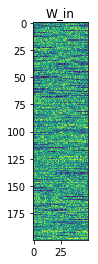

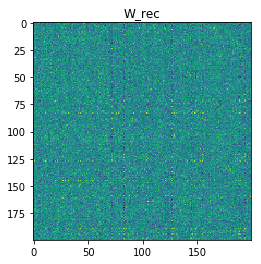

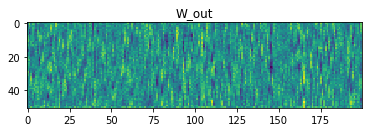

In [110]:
toplot = ['W_in', 'W_rec', 
 'W_out']
for key in toplot:
    plt.figure()
    plt.imshow(weights[key])
    plt.title(key)

In [111]:

# spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

In [112]:
import scipy.cluster.hierarchy as spc


In [113]:
def weight_sort_plot(W):
    this_W = W
    corr = np.corrcoef(this_W)
    pdist = spc.distance.pdist(corr)
    linkage = spc.linkage(pdist, method='complete')
    corr_idx = np.argsort(spc.fcluster(linkage, 0.5 * pdist.max(), 'distance'))
    corr_sort = np.corrcoef(this_W[corr_idx])
    max_idx = np.argsort(np.argmax(this_W,axis = 1))
    f,ax = plt.subplots(1,4,figsize = (16,4))
    ax[0].imshow(corr_sort,aspect = 'auto')
    ax[1].imshow(this_W,aspect = 'auto')
    ax[2].imshow(this_W[corr_idx,:],aspect = 'auto')
    ax[3].imshow(this_W[max_idx,:],aspect = 'auto')
     

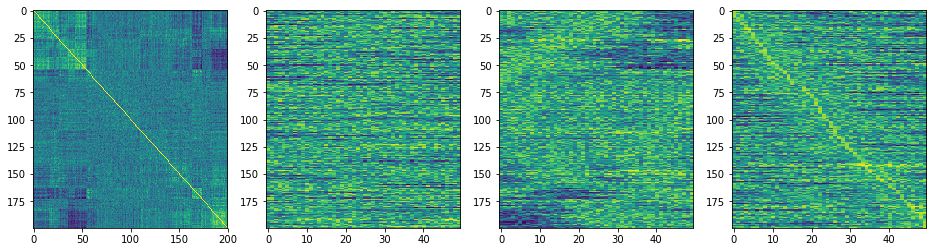

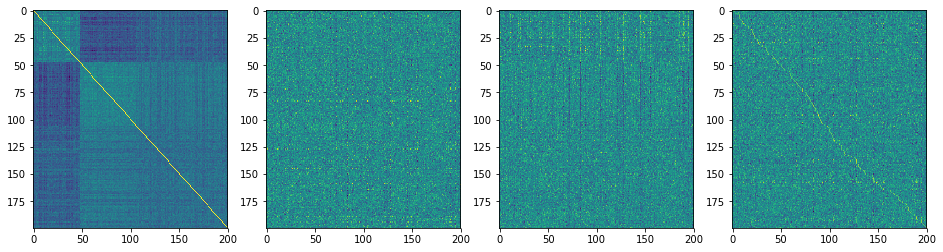

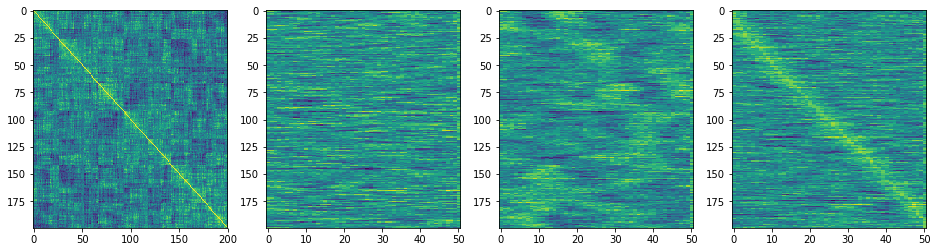

In [114]:
weight_sort_plot(weights['W_in'][E,:])
weight_sort_plot(weights['W_rec'][E,:])
weight_sort_plot(weights['W_out'][:,E].T)


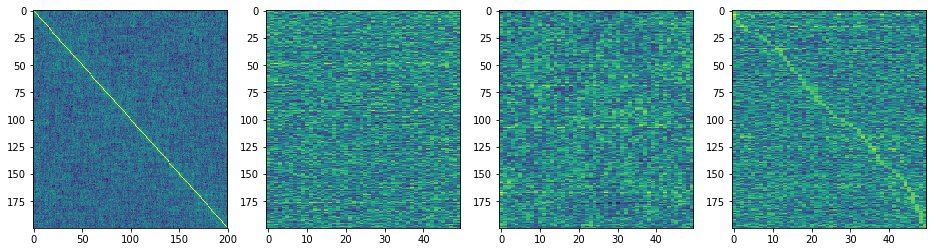

In [72]:
this_W = weights['W_in'][E,:]
# this_W = weights['W_out'][:,E].T
# this_W = weights['W_rec'][E,:]
corr = np.corrcoef(this_W)
pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
corr_idx = np.argsort(spc.fcluster(linkage, 0.5 * pdist.max(), 'distance'))
corr_sort = np.corrcoef(this_W[corr_idx])
max_idx = np.argsort(np.argmax(this_W,axis = 1))
f,ax = plt.subplots(1,4,figsize = (16,4))
ax[0].imshow(corr_sort,aspect = 'auto')
ax[1].imshow(this_W,aspect = 'auto')
ax[2].imshow(this_W[corr_idx,:],aspect = 'auto')
ax[3].imshow(this_W[max_idx,:],aspect = 'auto')
this_idx = max_idx



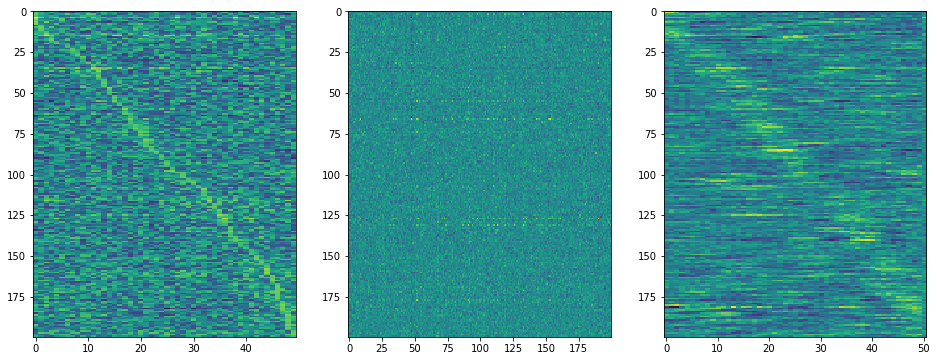

In [73]:
f,ax = plt.subplots(1,3,figsize = (16,6))
ax[0].imshow(weights['W_in'][this_idx,:],aspect = 'auto')
ax[1].imshow(weights['W_rec'][this_idx,:],aspect = 'auto')
ax[2].imshow(weights['W_out'][:,this_idx].T,aspect = 'auto')

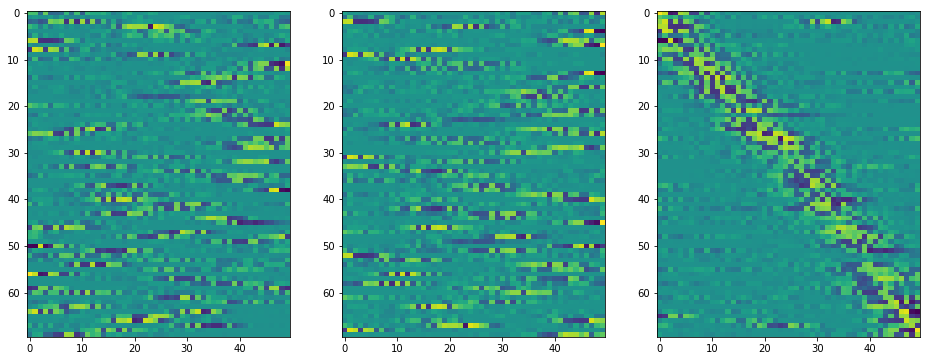

In [ ]:




corr = df.corr().values

pdist = spc.distance.pdist(corr)
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 0.5 * pdist.max(), 'distance')

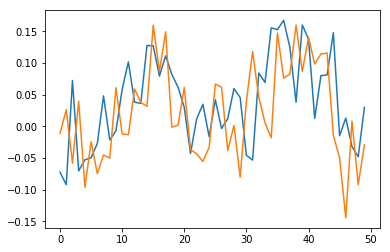

In [77]:
i = 8
plt.plot(weights['W_in'][i,:])
plt.plot(weights['W_out'][:,i])

In [63]:
N_rec = 10
dale_ratio = 0.8

In [64]:
dale_vec = np.ones(N_rec)
        
dale_vec[int(dale_ratio * N_rec):] = -1
dale_rec = np.diag(dale_vec)
dale_vec[int(dale_ratio * N_rec):] = 0
dale_out = np.diag(dale_vec)

In [65]:
dale_rec

array([[ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., -1.]])

Text(0.5, 1.0, 'Evolution of State Variables over Time')

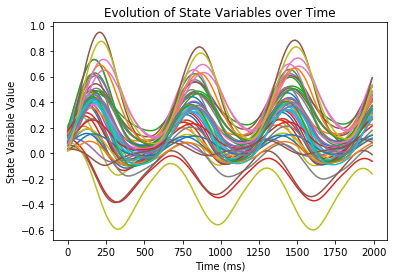

Clean up the model to clear out the tensorflow namespace

In [122]:
basicModel.destruct()

In [ ]:
def gaussian_psth(mu = 0 * ms, sigma = 0 * ms):
        time_bins = np.arange(0,T,dt)
        mu_ = mu 
        sigma_ = sigma  
        psth = (1/(sigma * np.sqrt(2 * np.pi)) *np.exp( - (time_bins - mu)**2 / (2 * sigma**2)))
        psth = psth/sum(psth)
        return psth,time_bins
    
def uniform_psth():
        time_bins = np.arange(0,T,dt)
        psth = np.ones(time_bins.shape)*dt/second
        return psth,time_bins

def spikes_from_psth(psth):
    return np.random.binomial(1,psth)

def generate_population_spikes(kernel,rates):
    spikes = []
    ind = []
    for i,r in enumerate(rates):
        this_spikes = np.where(spikes_from_psth(kernel*r))[0]
        this_ind = np.ones(this_spikes.shape) * i
        spikes.append(this_spikes)
        ind.append(this_ind)
    spikes = np.concatenate(spikes) *dt
    ind = np.concatenate(ind).astype(int)
    return spikes, ind    

def diff_of_exps(x_range,tau_rise = 1,tau_decay = 3, onset = 0):
    y = np.zeros(x_range.shape)
    for i,x in enumerate(x_range):
        y[i] = (1/np.exp((x-onset)/tau_decay)) - (1/np.exp((x-onset)/tau_rise))
    y[y<0] = 0
    return y 
#     onset_time = int(kernel_length*onset)
alpha_k = diff_of_exps(np.arange(30),tau_rise = 0.1,tau_decay = 3, onset = 14)   
plt.plot(np.arange(30),alpha_k)